In [1]:
from finetuning_utils import *

Using cuda as DEVICE


In [2]:
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
weights_dir = config['data']['model_weights'] 

### Initial Evaluation

In [4]:
model_name = 'loveda_DeepLabV3_r101_epochs15_lr0-07487'
model = torch.load(weights_dir + '/own_training/' + model_name + '/' + model_name + '_epoch14.pth.tar', 
                map_location=torch.device('cpu'))
model = model.to(DEVICE)
train_loader, test_loader = get_munich_tuning_loaders(batch_size=8)
display(calculate_accuracy(model, test_loader, 6))
calculate_accuracy(model, train_loader, 6)


Evaluating Accuracy on Test Set...


100%|██████████| 4/4 [00:55<00:00, 13.91s/it]


,Metric,Accuracy (%)
0,impervious,80.49000
1,building,64.17000
2,low vegetation,43.71000
3,trees,78.55000
4,Mean Accuracy,66.73000
5,Average Accuracy,69.77562



Evaluating Accuracy on Test Set...


100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


,Metric,Accuracy (%)
0,impervious,76.640000
1,building,67.450000
2,low vegetation,31.480000
3,trees,74.780000
4,Mean Accuracy,62.587500
5,Average Accuracy,66.150544


### Training

In [ ]:
FROZEN = True
# freezing backbone and training only the classifier
if FROZEN: # freeze all weights except last layer, i.e. clasification head
    for layer_name, param in model.named_parameters():
        if 'classifier' not in layer_name:
            param.requires_grad = False

model = model.to(DEVICE)

BATCH_SIZE = 8
LEARNING_RATE = 0.0926
NUM_EPOCHS = 4


train_loader, test_loader = get_munich_tuning_loaders(batch_size=BATCH_SIZE)
train_model(model, train_loader, test_loader, LEARNING_RATE=LEARNING_RATE, NUM_EPOCHS = NUM_EPOCHS)

In [ ]:
#torch.save(model, weights_dir + '/finetuning/model.pt')

In [ ]:
torch.random.initial_seed()

In [ ]:
torch_seed = 1807408335961436883


### Evaluation


In [7]:
model = torch.load(weights_dir + '/finetuning/model.pt')
model = model.to(DEVICE)
train_loader, test_loader = get_munich_tuning_loaders(batch_size=8)
calculate_accuracy(model, test_loader, 6)


Evaluating Accuracy on Test Set...


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]


,Metric,Accuracy (%)
0,impervious,72.670000
1,building,71.480000
2,low vegetation,77.220000
3,trees,88.070000
4,Mean Accuracy,77.360000
5,Average Accuracy,78.671621


In [8]:
calculate_accuracy(model, train_loader, 6)


Evaluating Accuracy on Test Set...


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


,Metric,Accuracy (%)
0,impervious,66.660000
1,building,76.020000
2,low vegetation,80.390000
3,trees,85.830000
4,Mean Accuracy,77.225000
5,Average Accuracy,76.500012


### Plot some predictions

In [9]:
inputs_and_preds = []
model.eval()  # set model to evaluation mode

with torch.no_grad():  # no need to track gradients
    for idx, (data, label) in enumerate(tqdm(train_loader)):
        if idx >3:
            break
        data = data.to(DEVICE)
        logits = model(data)['out']
        prob = torch.softmax(logits, dim=1)
        pred = torch.argmax(prob, dim=1)
        inputs_and_preds.append((data.cpu(), pred.cpu(), label.cpu()))



 27%|██▋       | 4/15 [00:02<00:05,  1.86it/s]


In [10]:
def denormalize(image, mean, std):
    image = image.clone().detach().numpy()  # Convert to numpy array
    image = image.transpose((1, 2, 0))  # Reshape (C, H, W) to (H, W, C)
    image = (image * std) + mean  # Denormalize
    image = image.clip(0, 1)  # Clip to range [0, 1]
    return image

def plot_random_images(inputs_preds_targets, idx2rgb, n):
    fig, ax = plt.subplots(n, 3, figsize=(15, 5*n))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(n):
        # Select a random batch
        inputs, preds, targets = random.choice(inputs_preds_targets)
        
        # Select a random image from the batch
        idx = random.randint(0, len(inputs) - 1)
        image = inputs[idx]
        image = denormalize(image, mean, std)  # Denormalize the image

        pred = preds[idx].numpy()
        target = targets[idx].numpy()

        # Create RGB images according to the colormap
        pred_rgb = np.zeros((*pred.shape, 3), dtype=np.uint8)
        target_rgb = np.zeros((*target.shape, 3), dtype=np.uint8)
        for cls, color in idx2rgb.items():
            pred_rgb[pred == cls] = color
            target_rgb[target == cls] = color

        # Plot original image
        ax[i, 0].imshow(image)
        ax[i, 0].axis('off')
        ax[i, 0].set_title(f'Original Image {i+1}')

        # Plot target image
        ax[i, 1].imshow(target_rgb)
        ax[i, 1].axis('off')
        ax[i, 1].set_title(f'Target Image {i+1}')

        # Plot predicted image
        ax[i, 2].imshow(pred_rgb)
        ax[i, 2].axis('off')
        ax[i, 2].set_title(f'Predicted Image {i+1}')

    plt.tight_layout()
    plt.show()


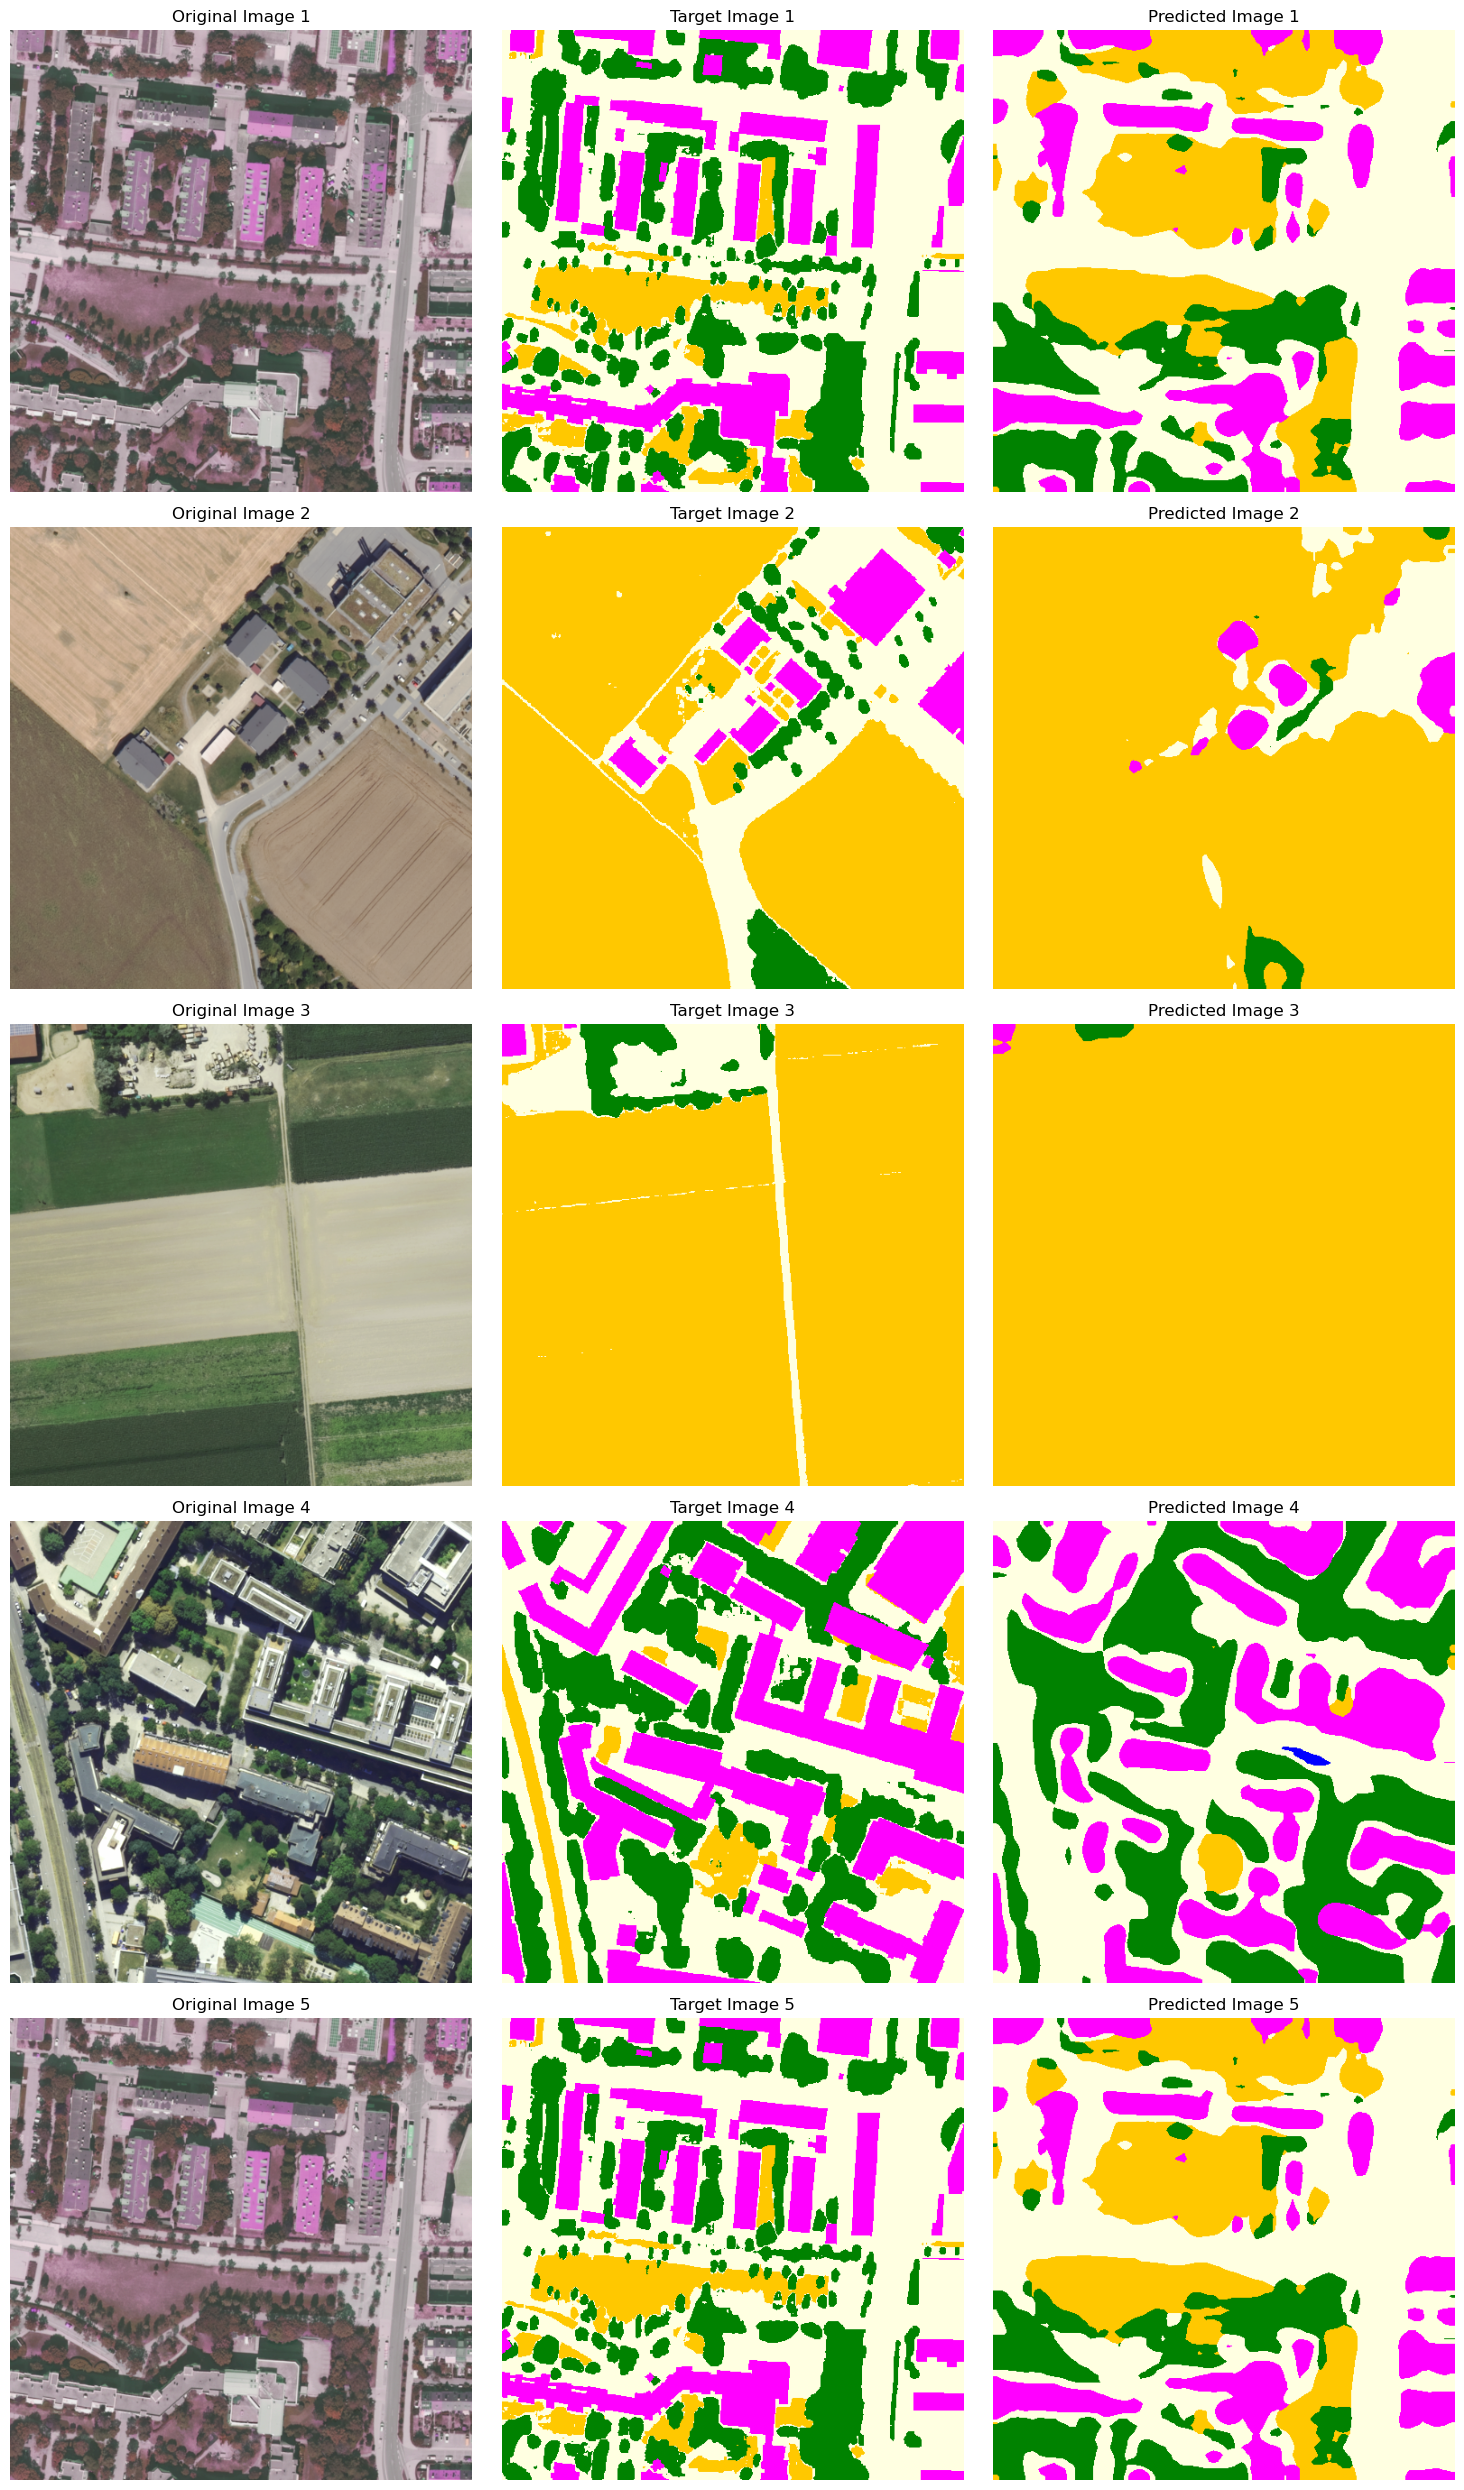

In [12]:
import time
t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)
plot_random_images(inputs_and_preds, idx2rgb, 5)